In [1]:
import torch
import time
from snn_delays.snn_refactored import SNN
from snn_delays.utils.dataset_loader import DatasetLoader
from snn_delays.utils.train_utils_refact_minimal import train, get_device, propagate_batch_simple
from snn_delays.utils.test_behavior import tb_minimal

'''
SHD dataset as in ablation study
'''

device = get_device()

# for reproducibility
torch.manual_seed(10)

dataset = 'ibm_gestures'
total_time = 50
batch_size = 64

# DATASET
DL = DatasetLoader(dataset=dataset,
                  caching='memory',
                  num_workers=0,
                  batch_size=batch_size,
                  total_time=total_time,
                  sensor_size_to = 32,
                  crop_to=1e6)

train_loader, test_loader, dataset_dict = DL.get_dataloaders()

Running on: cuda:0
[CropTime(min=0, max=1000000.0), Downsample(time_factor=1, spatial_factor=0.25, sensor_size=None, target_size=None), ToFrame(sensor_size=(32, 32, 2), time_window=None, event_count=None, n_time_bins=50, n_event_bins=None, overlap=0, include_incomplete=False)]


### Conv + 2 layer feedforward Without delays

Delta t: 20.0 ms
Epoch [1/20], learning_rates 0.001000, 0.100000
Step [5/16], Loss: 2.21072
Step [10/16], Loss: 2.12068
Step [15/16], Loss: 1.86091
Time elasped: 5.262969255447388
264
Test Loss: 1.7392822742462157
Avg spk_count per neuron for all 50 time-steps 2877.1992424242426
Test Accuracy of the model on the test samples: 37.121

max acc: 37.121212121212125
Epoch [2/20], learning_rates 0.001000, 0.100000
Step [5/16], Loss: 1.42441
Step [10/16], Loss: 1.43121
Step [15/16], Loss: 1.43525
Time elasped: 5.8049702644348145
264
Test Loss: 1.4093570232391357
Avg spk_count per neuron for all 50 time-steps 3117.700757575757
Test Accuracy of the model on the test samples: 53.409

max acc: 53.40909090909091
Epoch [3/20], learning_rates 0.001000, 0.100000
Step [5/16], Loss: 1.14547
Step [10/16], Loss: 1.17548
Step [15/16], Loss: 1.10997
Time elasped: 5.7734010219573975
264
Test Loss: 1.1863975763320922
Avg spk_count per neuron for all 50 time-steps 3037.9083333333333
Test Accuracy of the model

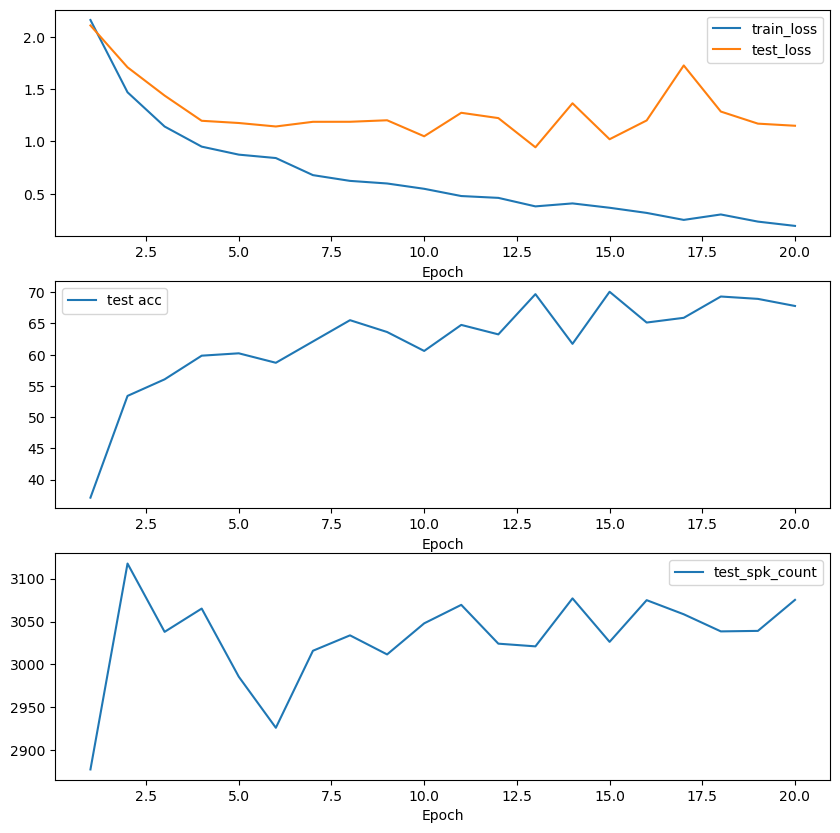

In [4]:
num_epochs = 20

lr = 1e-3

model_config = [
    {
        'type': 'Conv2D', 
        'out_channels': 16, 
        'kernel_size': 4 
    }, 
    {
        'type': 'Conv2D', 
        'out_channels': 24, 
        'kernel_size': 4 
    }, 
    {
        'type': 'Flatten'
    }, 
    {
        'type': 'Feedforward', 
        'num_out': 128 # Number of neurons in this dense layer
    },
    {
        'type': 'Feedforward', 
        'num_out': 128 # Number of neurons in this dense layer
    }
]

snn = SNN(dataset_dict=dataset_dict, model_config= model_config, tau_m=5.0, win=50, loss_fn='mem_sum', batch_size=batch_size, device=device)

snn._set_layers()
snn.to(device)

#torch.autograd.set_detect_anomaly(True)
train(snn, train_loader, test_loader, lr, num_epochs, test_behavior=tb_minimal, scheduler=(100, 0.95), test_every=1)

### Conv + 2 layer feedforward With 10 delays

Delta t: 20.0 ms
SNN(
  (layers): ModuleList(
    (0): Conv2DSNNLayer(
      (conv): Conv2d(2, 16, kernel_size=(4, 4), stride=(4, 4), bias=False)
    )
    (1): Conv2DSNNLayer(
      (conv): Conv2d(16, 24, kernel_size=(4, 4), stride=(4, 4), bias=False)
    )
    (2): FlattenSNNLayer()
    (3): FeedforwardSNNLayer(
      (linear): Linear(in_features=96, out_features=128, bias=False)
    )
    (4): FeedforwardSNNLayer(
      (linear): Linear(in_features=1280, out_features=128, bias=False)
    )
    (5): FeedforwardSNNLayer(
      (linear): Linear(in_features=128, out_features=11, bias=False)
    )
  )
  (criterion): CrossEntropyLoss()
)
Epoch [1/20], learning_rates 0.001000, 0.100000
Step [5/16], Loss: 2.18737
Step [10/16], Loss: 1.85024
Step [15/16], Loss: 1.70215
Time elasped: 6.1725194454193115
264
Test Loss: 1.5565243721008302
Avg spk_count per neuron for all 50 time-steps 2227.867424242424
Test Accuracy of the model on the test samples: 40.909

max acc: 40.90909090909091
Epoch [2/20

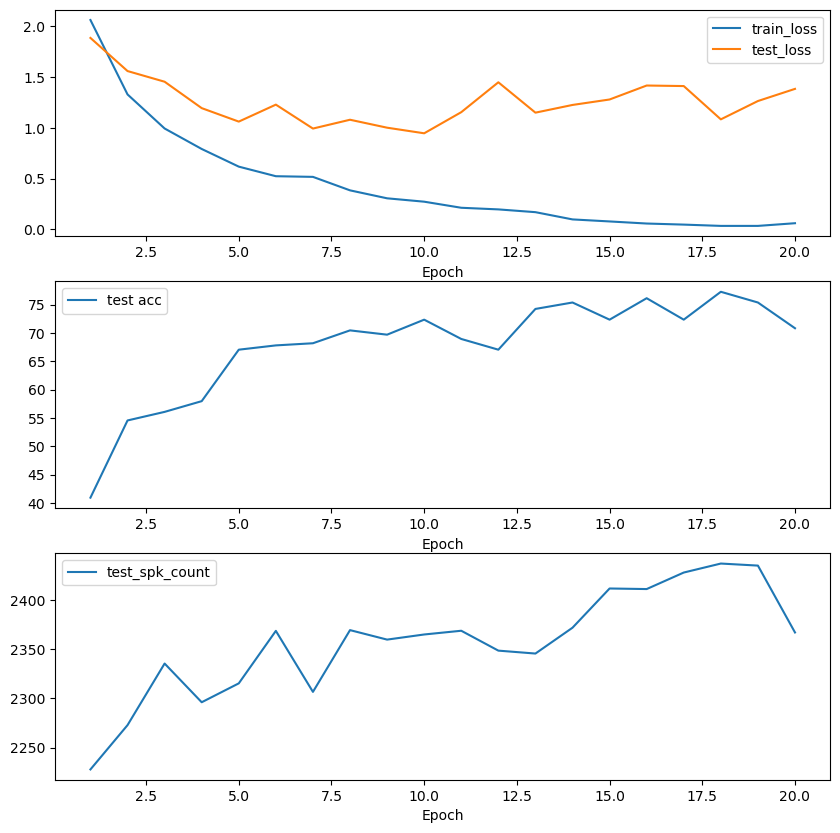

In [4]:
num_epochs = 20

lr = 1e-3

model_config = [
    {
        'type': 'Conv2D', 
        'out_channels': 16, 
        'kernel_size': 4 
    }, 
    {
        'type': 'Conv2D', 
        'out_channels': 24, 
        'kernel_size': 4 
    }, 
    {
        'type': 'Flatten'
    }, 
    {
        'type': 'Feedforward', 
        'num_out': 128, # Number of neurons in this dense layer
    },
    {
        'type': 'Feedforward', 
        'num_out': 128, # Number of neurons in this dense layer
        'fanin_delays': {'max_delay': 10, 'stride': 1}
    }
]

snn = SNN(dataset_dict=dataset_dict, model_config= model_config, tau_m=5.0, win=50, loss_fn='mem_sum', batch_size=batch_size, device=device)

snn._set_layers()
snn.to(device)

print(snn)

#torch.autograd.set_detect_anomaly(True)
train(snn, train_loader, test_loader, lr, num_epochs, test_behavior=tb_minimal, scheduler=(100, 0.95), test_every=1)

### Conv + 2 layer multifeedforward With 10

Delta t: 20.0 ms
SNN(
  (layers): ModuleList(
    (0): Conv2DSNNLayer(
      (conv): Conv2d(2, 16, kernel_size=(4, 4), stride=(4, 4), bias=False)
    )
    (1): Conv2DSNNLayer(
      (conv): Conv2d(16, 24, kernel_size=(4, 4), stride=(4, 4), bias=False)
    )
    (2): FlattenSNNLayer()
    (3): FeedforwardSNNLayer(
      (linear): Linear(in_features=96, out_features=128, bias=False)
    )
    (4): MultiFeedforwardSNNLayer(
      (linear): Linear(in_features=1280, out_features=128, bias=False)
    )
    (5): FeedforwardSNNLayer(
      (linear): Linear(in_features=128, out_features=11, bias=False)
    )
  )
  (criterion): CrossEntropyLoss()
)
Epoch [1/20], learning_rates 0.001000, 0.100000
Step [5/16], Loss: 2.23805
Step [10/16], Loss: 2.11605
Step [15/16], Loss: 1.81654
Time elasped: 5.026034355163574
264
Test Loss: 1.3833981156349182
Avg spk_count per neuron for all 50 time-steps 2096.6901515151512
Test Accuracy of the model on the test samples: 43.182

max acc: 43.18181818181818
Epoch 

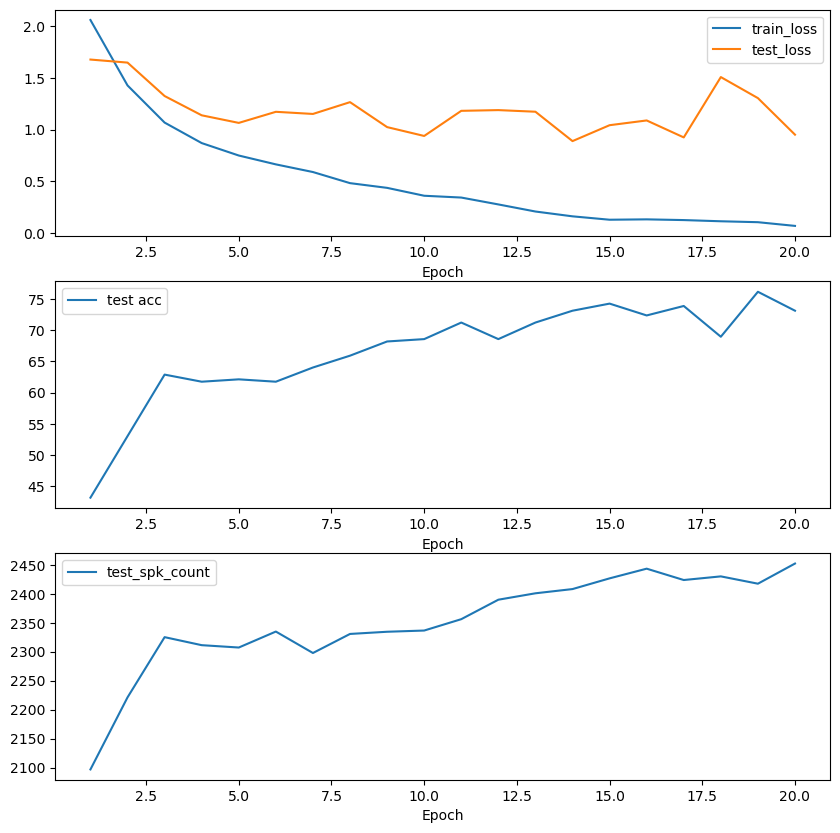

In [5]:
num_epochs = 20

lr = 1e-3

model_config = [
    {
        'type': 'Conv2D', 
        'out_channels': 16, 
        'kernel_size': 4 
    }, 
    {
        'type': 'Conv2D', 
        'out_channels': 24, 
        'kernel_size': 4 
    }, 
    {
        'type': 'Flatten'
    }, 
    {
        'type': 'Feedforward', 
        'num_out': 128, # Number of neurons in this dense layer
    },
    {
        'type': 'MultiFeedforward', 
        'num_out': 128, # Number of neurons in this dense layer
        'num_fanin_multifeedforward': 10
    }
]

snn = SNN(dataset_dict=dataset_dict, model_config= model_config, tau_m=5.0, win=50, loss_fn='mem_sum', batch_size=batch_size, device=device)

snn._set_layers()
snn.to(device)

print(snn)

#torch.autograd.set_detect_anomaly(True)
train(snn, train_loader, test_loader, lr, num_epochs, test_behavior=tb_minimal, scheduler=(100, 0.95), test_every=1)

### Conv + 2 recurrent nets

Delta t: 20.0 ms
SNN(
  (layers): ModuleList(
    (0): Conv2DSNNLayer(
      (conv): Conv2d(2, 16, kernel_size=(4, 4), stride=(4, 4), bias=False)
    )
    (1): Conv2DSNNLayer(
      (conv): Conv2d(16, 24, kernel_size=(4, 4), stride=(4, 4), bias=False)
    )
    (2): FlattenSNNLayer()
    (3): RecurrentSNNLayer(
      (linear): Linear(in_features=96, out_features=128, bias=False)
      (linear_rec): Linear(in_features=128, out_features=128, bias=False)
    )
    (4): RecurrentSNNLayer(
      (linear): Linear(in_features=128, out_features=128, bias=False)
      (linear_rec): Linear(in_features=128, out_features=128, bias=False)
    )
    (5): FeedforwardSNNLayer(
      (linear): Linear(in_features=128, out_features=11, bias=False)
    )
  )
  (criterion): CrossEntropyLoss()
)
Epoch [1/20], learning_rates 0.001000, 0.100000
Step [5/16], Loss: 2.39709
Step [10/16], Loss: 2.27551
Step [15/16], Loss: 2.17058
Time elasped: 5.766279220581055
264
Test Loss: 2.137963962554932
Avg spk_count per 

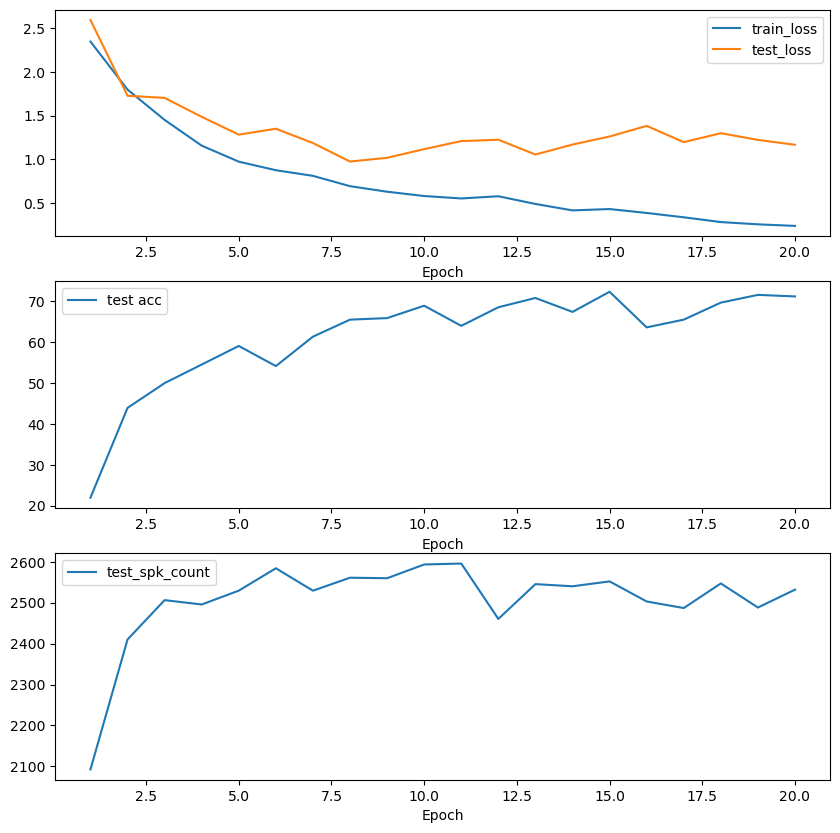

In [6]:
num_epochs = 20

lr = 1e-3

model_config = [
    {
        'type': 'Conv2D', 
        'out_channels': 16, 
        'kernel_size': 4 
    }, 
    {
        'type': 'Conv2D', 
        'out_channels': 24, 
        'kernel_size': 4 
    }, 
    {
        'type': 'Flatten'
    }, 
    {
        'type': 'Recurrent', 
        'num_out': 128, # Number of neurons in this dense layer
    },
    {
        'type': 'Recurrent', 
        'num_out': 128, # Number of neurons in this dense layer
    }
]

snn = SNN(dataset_dict=dataset_dict, model_config= model_config, tau_m=5.0, win=50, loss_fn='mem_sum', batch_size=batch_size, device=device)

snn._set_layers()
snn.to(device)

print(snn)

#torch.autograd.set_detect_anomaly(True)
train(snn, train_loader, test_loader, lr, num_epochs, test_behavior=tb_minimal, scheduler=(100, 0.95), test_every=1)

### Similar to BAM-SLDK
Same number of layers and num_outs, similar kernels sizes, but convs have no delays. Also no average-pooling, no BNTT.

In [7]:
dataset = 'ibm_gestures'
total_time = 50
batch_size = 32

# DATASET
DL = DatasetLoader(dataset=dataset,
                  caching='memory',
                  num_workers=0,
                  batch_size=batch_size,
                  total_time=total_time,
                  sensor_size_to = 64,
                  crop_to=3e6) # verified in BAM-SLDK code

train_loader, test_loader, dataset_dict = DL.get_dataloaders()

[CropTime(min=0, max=3000000.0), Downsample(time_factor=1, spatial_factor=0.5, sensor_size=None, target_size=None), ToFrame(sensor_size=(64, 64, 2), time_window=None, event_count=None, n_time_bins=50, n_event_bins=None, overlap=0, include_incomplete=False)]


Delta t: 60.0 ms
SNN(
  (layers): ModuleList(
    (0): Conv2DSNNLayer(
      (conv): Conv2d(2, 10, kernel_size=(4, 4), stride=(4, 4), bias=False)
    )
    (1): Conv2DSNNLayer(
      (conv): Conv2d(10, 24, kernel_size=(4, 4), stride=(4, 4), bias=False)
    )
    (2): Conv2DSNNLayer(
      (conv): Conv2d(24, 48, kernel_size=(2, 2), stride=(2, 2), bias=False)
    )
    (3): FlattenSNNLayer()
    (4): FeedforwardSNNLayer(
      (linear): Linear(in_features=3840, out_features=20, bias=False)
    )
    (5): FeedforwardSNNLayer(
      (linear): Linear(in_features=20, out_features=11, bias=False)
    )
  )
  (criterion): CrossEntropyLoss()
)
Epoch [1/50], learning_rates 0.001000, 0.100000


c:\Users\Alberto\anaconda3\envs\deeplearning\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Step [11/33], Loss: 2.08391
Step [22/33], Loss: 2.03159
Step [33/33], Loss: 1.24471
Time elasped: 86.38348746299744
264
Test Loss: 1.509450329674615
Avg spk_count per neuron for all 50 time-steps 3656.8371212121206
Test Accuracy of the model on the test samples: 45.455

max acc: 45.45454545454545
Epoch [2/50], learning_rates 0.001000, 0.100000
Step [11/33], Loss: 1.70929
Step [22/33], Loss: 1.25103
Step [33/33], Loss: 1.05153
Time elasped: 11.21901559829712
264
Test Loss: 1.3433611790339153
Avg spk_count per neuron for all 50 time-steps 3681.8386363636364
Test Accuracy of the model on the test samples: 54.167

max acc: 54.166666666666664
Epoch [3/50], learning_rates 0.001000, 0.100000
Step [11/33], Loss: 1.09146
Step [22/33], Loss: 0.90726
Step [33/33], Loss: 0.88704
Time elasped: 11.401008605957031
264
Test Loss: 1.108529680305057
Avg spk_count per neuron for all 50 time-steps 3706.725
Test Accuracy of the model on the test samples: 59.091

max acc: 59.09090909090909
Epoch [4/50], lea

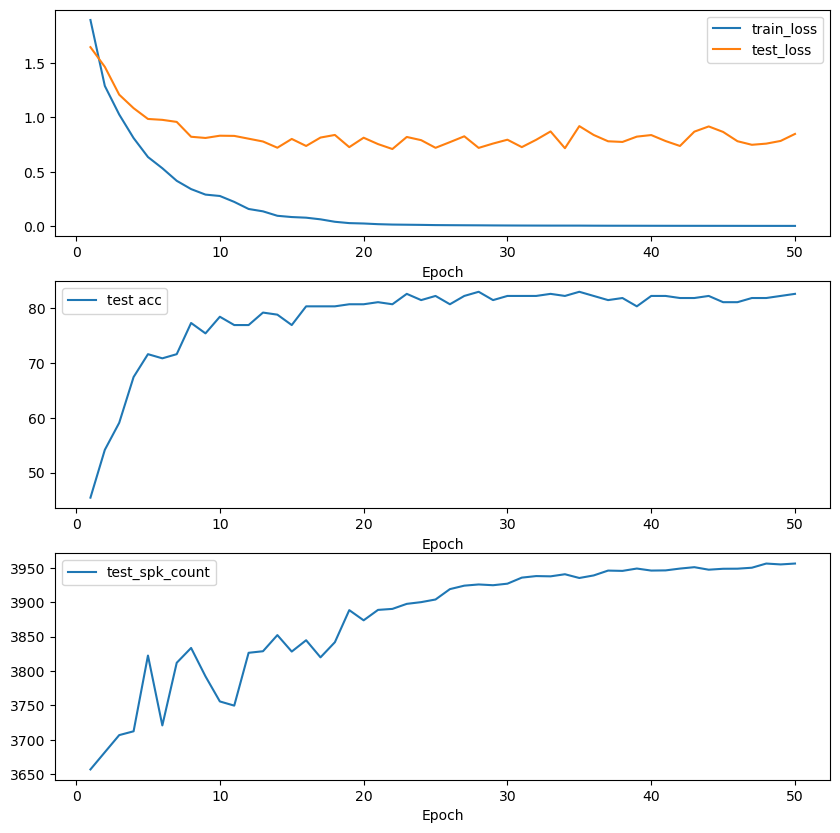

In [8]:
num_epochs = 50

lr = 1e-3

model_config = [
    {
        'type': 'Conv2D', 
        'out_channels': 10, 
        'kernel_size': 4 
    }, 
    {
        'type': 'Conv2D', 
        'out_channels': 24, 
        'kernel_size': 4 
    }, 
    {
        'type': 'Conv2D', 
        'out_channels': 48, 
        'kernel_size': 2 
    }, 
    {
        'type': 'Flatten'
    }, 
    {
        'type': 'Feedforward', 
        'num_out': 20, # Number of neurons in this dense layer
        'fanin_delays': {'max_delay': 20, 'stride': 1}
        
    }
]

snn = SNN(dataset_dict=dataset_dict, model_config= model_config, tau_m=5.0, win=50, loss_fn='mem_sum', batch_size=batch_size, device=device)

snn._set_layers()
snn.to(device)

print(snn)

#torch.autograd.set_detect_anomaly(True)
train(snn, train_loader, test_loader, lr, num_epochs, test_behavior=tb_minimal, scheduler=(100, 0.95), test_every=1)